In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer,TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RepeatedKFold,StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from GridCV import Hypertuner_proba

sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12, 'font.style': 'normal', 'font.family':'palatino'})


In [2]:
data = pd.read_csv("Data/train.csv")
data["y"] = np.where(data["y"] == 1,0,1)
#data.head()

In [3]:
test_data = pd.read_csv("Data/test.csv")
#test_data

In [4]:
corrs = data.corr()
corrs.style.background_gradient(cmap = "coolwarm")

In [5]:
#Checking for na-values
data.isna().sum()

In [7]:
#Check for collinearity of some of the categorial columns

print("TV and Movies packages grouped and counted")
print("-"*50)
data.groupby(["TV","movies"]).size()

In [8]:
#Creating the new fields discussed in the report. 

data["new_customer"] = np.where(data["time"] == 0,1,0)
test_data["new_customer"] = np.where(test_data["time"] == 0,1,0)

data["avg_charges"] = data["chargesTotal"]/data["time"]
test_data["avg_charges"] = test_data["chargesTotal"]/test_data["time"]

data.loc[data["avg_charges"].isna(),"avg_charges"] = data["chargesMonth"]
test_data.loc[test_data["avg_charges"].isna(),"avg_charges"] = test_data["chargesMonth"]

data["month_vs_avg"] = data["chargesMonth"]/data["avg_charges"]
test_data["month_vs_avg"] = test_data["chargesMonth"]/test_data["avg_charges"]

In [9]:
data = data.drop(["avg_charges","chargesTotal"],axis = 1)
test_data = test_data.drop(["avg_charges","chargesTotal"],axis = 1)

In [10]:
corrs = data.corr()
corrs.style.background_gradient(cmap = "coolwarm")

In [11]:
#This prints for each of the categorical values the share of customers who churn

categorical_columns = list(data.columns[data.dtypes == object])

categorical_columns.append("senior")
for col in categorical_columns:
    print()
    print(f"Churn rate grouped by {col}")
    print("-"*30)
    print(data.groupby(col).agg({"y":["mean","count"]}))

categorical_columns = list(data.columns[data.dtypes == object])
num_cols = ['time', 'chargesMonth', 'month_vs_avg']

In [12]:
#Phone is the higher level of lines and is hence perfectly multicollinear with it. It can be dropped. 

data = data.drop("phone",axis = 1)
test_data = test_data.drop("phone",axis = 1)

In [13]:
#Violin plots for interaction checking 

fig,axs = plt.subplots(1,3,figsize = (16,6))

for i,ax in enumerate(fig.axes):
    ax.set_title(f"Distribution of {num_cols[i]}")
    sns.violinplot(x = "internet", y = num_cols[i],hue = "y",data = data,ax = ax,split=True)

'fig,axs = plt.subplots(1,3,figsize = (16,6))\n\nfor i,ax in enumerate(fig.axes):\n    ax.set_title(f"Distribution of {num_cols[i]}")\n    sns.violinplot(x = "internet", y = num_cols[i],hue = "y",data = data,ax = ax,split=True)'

In [14]:
#Boxplots of the continuouse variables across y

fig, axs = plt.subplots(1,2, figsize = (13,4))

ax = axs[0]
sns.boxplot(x = "y",y = "time",data = data,ax = ax)
ax.set_title("Boxplot time over y")

ax = axs[1]
sns.boxplot(x = "y",y = "chargesMonth",data = data,ax = ax)
ax.set_title("Boxplot monthly charges over y")

'fig, axs = plt.subplots(1,2, figsize = (13,4))\n\nax = axs[0]\nsns.boxplot(x = "y",y = "time",data = data,ax = ax)\nax.set_title("Boxplot time over y")\n\nax = axs[1]\nsns.boxplot(x = "y",y = "chargesMonth",data = data,ax = ax)\nax.set_title("Boxplot monthly charges over y")\n'

In [16]:
#Lets first make a random forest classifier
X = data.iloc[:,1:]
y = data["y"]
categorical_columns = X.columns[X.dtypes == object]
cv = StratifiedKFold(5)

In [17]:
#Creating the function for the weighted accuracy

def weighted_accuracy_score(y, y_hat,**kwargs):
    confusion = confusion_matrix(y,y_hat)
    valueTotal = confusion[1,0]*5+confusion[0,1]*1
    return valueTotal

#### Bagging

In [18]:

from sklearn.ensemble import BaggingClassifier

categorical_cols = OrdinalEncoder()

column_transformer_bag = ColumnTransformer([
    ("cat_trans", categorical_cols, categorical_columns)], remainder = "passthrough")

pipeline_bag = Pipeline(steps = [
    ("transformer", column_transformer_bag),
    ("model", BaggingClassifier(DecisionTreeClassifier(class_weight = {0: 1, 1: 5}),n_jobs = -1))
])

parameters_bag = {"model__n_estimators": [200],
              "model__base_estimator__min_samples_split": [2,4,6,8,16],
              "model__base_estimator__min_samples_leaf": [1,2,3,4,8]
             }
search_Bagging = Hypterunter_proba(pipeline,parameters,scoring = weighted_accuracy_score,prob_range = np.arange(0.1,1,0.1) )
search_Bagging.fit(X,y)
search_Bagging.best_params,search_Bagging.best_mean_score,search_Bagging.best_prob

#### Random Forest

In [72]:
categorical_col_RF = OrdinalEncoder()

column_transformer_RF = ColumnTransformer([
    ("cat_trans", categorical_col_RF, categorical_columns)], remainder = "passthrough")

pipeline_RF = Pipeline(steps = [
    ("transformer", column_transformer_RF),
    ("model", RandomForestClassifier(class_weight = {0: 1, 1: 5},n_jobs = -1))
])

parameters_RF = {"model__n_estimators": [200],
              "model__max_features": [0.2,0.5,"sqrt","log2"],
              "model__max_depth" : [None,5,10]
             }
search_RF = Hypertuner_proba(pipeline_RF,parameters_RF,scoring = weighted_accuracy_score,prob_range = np.arange(0.1,1,0.1) )
search_RF.fit(X,y)

In [29]:
def printer(search):
    for key,val in search.best_params.items():
        print(f"Parameter {key}: {val}")
    print(f"Probability {search.best_prob}")
    print(f"Mean cross-validation error: {search.best_mean_score}, std {search.best_cv_scores_std}")
printer(search_RF)
search_RF.best_mean_score,search_RF.best_cv_scores_std

(363.93333333333334, 27.52324270301174)

In [31]:
pipeline_RF.set_params(**search_RF.best_params)

pipeline_RF.fit(X,y)
y_hat_RF = np.where(pipeline_RF.predict_proba(test_data)[:,1] >= 0.5,1,0)+1

#### Adaboosting

In [73]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder


categorical_cols = OneHotEncoder()

column_transformer_ada = ColumnTransformer([
    ("cat_trans", categorical_cols, categorical_columns)], remainder = "passthrough")

pipeline_ada = Pipeline(steps = [
    ("transformer", column_transformer_ada),
    ("model", AdaBoostClassifier(DecisionTreeClassifier(class_weight={0:1,1:5})))
])


parameters_ada = {"model__n_estimators": [300,400,500],
              "model__learning_rate": [0.04,0.05,0.06],
              "model__base_estimator__max_depth": [1],
             }

search_Ada = Hypertuner_proba(pipeline_ada,parameters_ada,scoring = weighted_accuracy_score,prob_range = np.arange(0.2,0.9,0.1),cv = StratifiedKFold(n_splits=5))
search_Ada.fit(X,y)
printer(search_Ada)

In [35]:
pipeline_ada.set_params(**search_Ada.best_params)
pipeline_ada.fit(X,y)
y_hat_Ada = np.where(pipeline_ada.predict_proba(test_data)[:,1] >= 0.5,1,0)+1

#### Gradient Boosting Classifier


In [74]:
from sklearn.ensemble import GradientBoostingClassifier

categorical_cols = OrdinalEncoder()

column_transformer_XGBoost = ColumnTransformer([
    ("cat_trans", categorical_cols, categorical_columns)], remainder = "passthrough")

pipeline_XGBoost = Pipeline(steps = [
    ("transformer", column_transformer_XGBoost),
    ("model", GradientBoostingClassifier())
])

parameters_ada = {"model__n_estimators": [400,500],
              "model__learning_rate": [0.05,0.1],
              "model__subsample": [0.5,0.6],
              "model__max_depth": [1]
             }

search_GBoost = Hypertuner_proba(pipeline_XGBoost,parameters_ada,scoring = weighted_accuracy_score,prob_range = np.arange(0.2,0.9,0.1),cv = StratifiedKFold(n_splits=5))
search_GBoost.fit(X,y)
printer(search_GBoost)

#### Logistic Regression

In [52]:
from sklearn.preprocessing import OneHotEncoder
from GridCV import Hypertuner_proba

categorical_cols = Pipeline(steps = [
    ("encode", OneHotEncoder(handle_unknown="ignore"))

])

num_transformer_logit  = Pipeline(steps = [
    ("polynomial", PolynomialFeatures()),
    ("scale", StandardScaler())
])

column_transformer_logit = ColumnTransformer([
    ("cat_trans", categorical_cols, categorical_columns),
    ("num_trans", num_transformer_logit, num_cols)
],remainder = "passthrough")


pipeline_logit = Pipeline(steps = [
    ("transformer", column_transformer_logit),
    ("model", LogisticRegression(penalty = "l2",class_weight = {0:1,1:5},solver = "lbfgs",max_iter=2000))
])


parameters_logit = {"model__C": [0.01,0.1,0.3,0.5,1,1.5,2,2.5,3,5],
              "transformer__num_trans__polynomial__degree": [3]
             }


search_logit = Hypertuner_proba(pipeline_logit,parameters_logit,scoring = weighted_accuracy_score,prob_range = np.arange(0.2,0.9,0.1),cv = StratifiedKFold(n_splits=5))
search_logit.fit(X,y)
printer(search_logit)

In [55]:
#Plot for the error scores 

results_logit = search_logit.grid_search_results

x = results_logit.loc[results_logit["prob"] == search_logit.best_prob]

plt.plot(x["params"].apply(pd.Series)["model__C"],x["mean_score"])
plt.title("CV_Scores across different levels of regularization")
plt.xlabel("Reg. parameter")
plt.ylabel("Error Score")

'results_logit = search_logit.grid_search_results\n\nx = results_logit.loc[results_logit["prob"] == search_logit.best_prob]\n\nplt.plot(x["params"].apply(pd.Series)["model__C"],x["mean_score"])\nplt.title("CV_Scores across different levels of regularization")\nplt.xlabel("Reg. parameter")\nplt.ylabel("Error Score")'

In [58]:
pipeline_logit.set_params(**search_logit.best_params)
pipeline_logit.fit(X,y)
y_hat_Logit = np.where(pipeline_logit.predict_proba(test_data)[:,1] > search_logit.best_prob,1,0)+1

#### LDA 

In [76]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest,chi2,SelectFromModel
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold

categorical_cols = OneHotEncoder(handle_unknown="ignore")

num_transformer_LDA  = Pipeline(steps = [
    ("polynomial", PolynomialFeatures()),
    ("scale", StandardScaler())
])

column_transformer_LDA = ColumnTransformer([
    ("cat_trans", categorical_cols, categorical_columns),
    ("num_trans", num_transformer_LDA, num_cols)

],remainder = "passthrough")


pipeline_LDA = Pipeline(steps = [
    ("transformer", column_transformer_LDA),
    ("selector",SelectFromModel(DecisionTreeClassifier(class_weight = {0:1,1:5}))),
    ("model", LinearDiscriminantAnalysis())
])

parameters_LDA = {
             "selector__threshold": ["0*mean","0.001*mean","0.002*mean"],
             "transformer__num_trans__polynomial__degree" : [3],
             "model__priors" : [[0.32,0.68],[0.3,0.7],[0.4,0.6],[0.5,0.5]],
}

search_LDA = Hypertuner_proba(pipeline_LDA,parameters_LDA,scoring = weighted_accuracy_score,prob_range = np.arange(0.2,0.9,0.1),cv = StratifiedKFold(n_splits=5))
search_LDA.fit(X,y)
printer(search_LDA)

In [64]:
pipeline_LDA.set_params(**search_LDA.best_params)
pipeline_LDA.fit(X,y)
probs_train = pipeline_LDA.predict_proba(X)
y_hat_LDA = np.where(pipeline_LDA.predict_proba(test_data)[:,1] > 0.5,1,0)+1


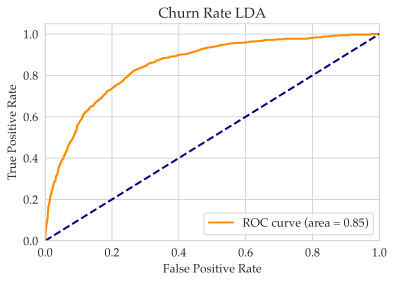

In [79]:
from sklearn.metrics import roc_curve, auc

fpr,tpr,_ = roc_curve(y,probs_train[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Churn Rate LDA')
plt.legend(loc="lower right")
plt.show()


#### Multilayer Perceptron

In [ ]:
#columns to drop when onehot encoding - removes multicollinearity
drop_column = ["Male","No","No phone service","No","No internet service","No internet service","No internet service",
             "No internet service","No internet service","No internet service","No","Mailed check"]
categorical_col_MLP = OneHotEncoder(drop= drop_column)

column_transformer_MLP = ColumnTransformer([
    ("cat_trans", categorical_col_MLP, categorical_columns)], remainder = "passthrough")

pipeline_MLP = Pipeline(steps = [
    ("transformer", column_transformer_MLP),
    ("model", MLPClassifier(max_iter = 500,n_iter_no_change=5,tol = 1e-3)) ])

parameters_MLP = {"model__batch_size": [128,256],
              "model__learning_rate": ["adaptive"],
              "model__learning_rate_init" : [0.0008,0.0005],
              "model__hidden_layer_sizes" : [(100),(128)],
              "model__alpha":[0.0001],
              "model__solver" : ["adam"]        
             }
search_MLP = Hypterunter_proba(pipeline_MLP,parameters_MLP,scoring = weighted_accuracy_score,prob_range = np.arange(0.2,0.9,0.1) )
search_MLP.fit(X,y)

In [24]:
search_MLP.best_params,search_MLP.best_mean_score,search_MLP.best_prob

#### Model Stacking
More was done but not shown due to page limit requirements.

In [78]:
models = {"LDA": y_hat_LDA,"Ada": y_hat_Ada,"RF": y_hat_RF, "Logit" : y_hat_Logit}
stacker = pd.DataFrame(models)
corrs = stacker.corr()
corrs.style.background_gradient(cmap = "coolwarm")

In [70]:
#Selction throigh majority vote
y_hat_majority = np.where(stacker.sum(axis = 1) > 5, 2,1)

In [71]:
with open("Data/final_Majority_Vote_7.txt","w") as file:
    for i in y_hat_majority:
        file.writelines(f"{i}\n")